In [18]:
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cbook as cbook
from matplotlib import cm

from scipy.optimize import curve_fit
import scipy.constants as c

from photutils.datasets import load_star_image
from photutils.detection import DAOStarFinder
from photutils.aperture import CircularAnnulus
from photutils.aperture import aperture_photometry

from astropy.io import fits
import astropy.units as u
from astropy.table import Table, Column, hstack, vstack
from astropy.utils.data import get_pkg_data_filename
from astropy.wcs import WCS
from astropy.table import Table
from astropy.io import fits
from astropy.stats import sigma_clipped_stats

In [19]:
I_hdu = fits.open(get_pkg_data_filename(r'C:\Users\woutg\OneDrive - Universiteit Leiden\Universiteit Leiden\Bachelor 3\BRP\Meerkat_Data\Abell 85/Abell_85_aFix_pol_I_Farcsec_fcube_cor.fits'))[0]
I_cube = I_hdu.data[0]
Q_hdu = fits.open(get_pkg_data_filename(r'C:\Users\woutg\OneDrive - Universiteit Leiden\Universiteit Leiden\Bachelor 3\BRP\Meerkat_Data\Abell 85/Abell_85_aFix_pol_Q_Farcsec_fcube_cor.fits'))[0]
Q_cube = Q_hdu.data[0]
U_hdu = fits.open(get_pkg_data_filename(r'C:\Users\woutg\OneDrive - Universiteit Leiden\Universiteit Leiden\Bachelor 3\BRP\Meerkat_Data\Abell 85/Abell_85_aFix_pol_U_Farcsec_fcube_cor.fits'))[0]
U_cube = U_hdu.data[0]
V_hdu = fits.open(get_pkg_data_filename(r'C:\Users\woutg\OneDrive - Universiteit Leiden\Universiteit Leiden\Bachelor 3\BRP\Meerkat_Data\Abell 85/Abell_85_aFix_pol_V_Farcsec_fcube_cor.fits'))[0]
V_cube = V_hdu.data[0]

I_freqmean = np.nanmean(I_cube, axis=0)
Q_freqmean = np.nanmean(Q_cube, axis=0)
U_freqmean = np.nanmean(U_cube, axis=0)
V_freqmean = np.nanmean(V_cube, axis=0)


I_wcs = WCS(I_hdu.header)
Q_wcs = WCS(Q_hdu.header)
U_wcs = WCS(U_hdu.header)
V_wcs = WCS(V_hdu.header)

freqs_lower = np.zeros(12)
freqs_middle = np.zeros(12)
freqs_upper = np.zeros(12)

for n in range(12):
    number = str((4-len(str(n+1)))*'0'+str(n+1))
    freqs_lower[n] = I_hdu.header['FREL'+number]
    freqs_middle[n] = I_hdu.header['FREQ'+number]
    freqs_upper[n] = I_hdu.header['FREH'+number]

0001
0002
0003
0004
0005
0006
0007
0008
0009
0010
0011
0012


In [40]:
linpol_intens_cube = np.sqrt(Q_cube**2+U_cube**2)
linpol_intens_freqmean = np.nanmean(linpol_intens_cube, axis=0)

Linpol_hdu = fits.PrimaryHDU(linpol_intens_cube)
Linpol_hdu.writeto(r'C:\Users\woutg\OneDrive - Universiteit Leiden\Universiteit Leiden\Bachelor 3\BRP\Meerkat_Data\Abell 85\Abell_85_Linpol_Farcsec_fcube_cor.fits', overwrite=True)

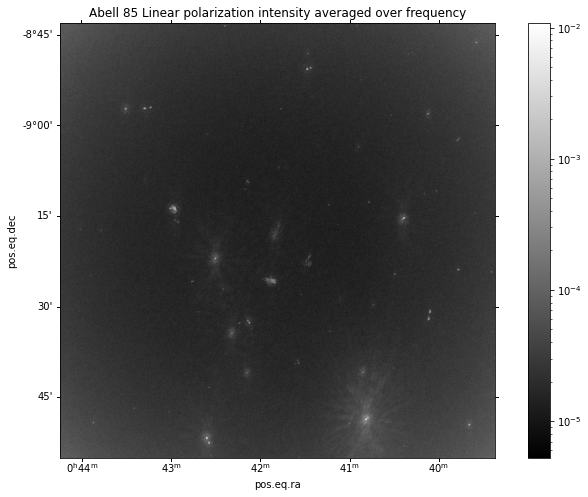

In [21]:
plt.figure(figsize=(12,8))
plt.subplot(projection=I_wcs, slices=('x', 'y', 0, 0))
plt.title('Abell 85 Linear polarization intensity averaged over frequency')
plt.imshow(linpol_intens_freqmean.clip(min=0.0000001), cmap='gray', norm=colors.LogNorm())
plt.colorbar()
plt.savefig('ACO85_Linpol_Freqmean.pdf', dpi=500)

In [22]:
backgr_mean, backgr_median, backgr_std = sigma_clipped_stats(linpol_intens_freqmean, sigma=3.0)
print((backgr_mean, backgr_median, backgr_std))

(2.2228118e-05, 2.056794e-05, 7.4738346e-06)


In [23]:
daofind = DAOStarFinder(fwhm=3.0, threshold=np.sqrt(12)*3*backgr_std)
sources = daofind(linpol_intens_freqmean - backgr_median)
for col in sources.colnames:
    sources[col].info.format = '%.8g'  # for consistent table output
print(sources)

 id xcentroid ycentroid sharpness  ... sky      peak        flux       mag     
--- --------- --------- ---------- ... --- ------------- --------- ------------
  1 1240.3743 125.05221 0.40063999 ...   0  0.0031750763 12.902322   -2.7766697
  2 1219.7997  167.3948 0.39890794 ...   0  0.0059659723 19.834065   -3.2435293
  3 3402.9638  276.6438 0.39958119 ...   0  0.0025882686 9.3137564   -2.4228122
  4  276.9332 292.87753 0.39891927 ...   0 0.00044727101 1.6578485  -0.54886213
  5 2536.2357 303.70036 0.40582735 ...   0  0.0004094062 1.0213854 -0.022974133
  6 2550.9457 307.30776 0.39009826 ...   0 0.00038503329 1.0856967 -0.089271269
  7 2540.8233 309.27523 0.40376552 ...   0  0.0005052943 1.3174664  -0.29934885
  8 2530.1416 311.28941 0.40689776 ...   0 0.00039638649 1.3044421  -0.28856199
  9 2544.4722   321.465 0.39895931 ...   0   0.010829131 38.245097   -3.9564394
 10 2532.3276  323.0863 0.40942622 ...   0 0.00038384809 1.3148333  -0.29717675
...       ...       ...        ... ... .

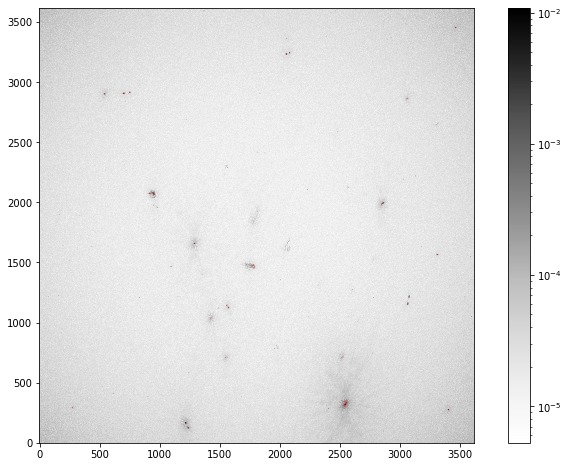

In [24]:
from photutils.aperture import CircularAperture

positions = np.transpose((sources['xcentroid'], sources['ycentroid']))
apertures = CircularAperture(positions, r=7.)

plt.figure(figsize=(12,8))
plt.imshow(linpol_intens_freqmean.clip(min=0.0000001), cmap='Greys', origin='lower', norm=colors.LogNorm(), interpolation='nearest')
plt.colorbar()
apertures.plot(color='red', lw=0.1)
plt.savefig('ACO85_Linpol_FreqmeanSourcedetect.pdf', dpi=300)

In [25]:
FWHM_major_axis = 2.140979E-03*c.degree
FWHM_minor_axis = 1.972437E-03*c.degree
pixsize = 3.317774E-04*c.degree
print(FWHM_major_axis)

def photometry(data_local, apers_local):
    data_local_intensity = data_local*4*np.log(2)/(np.pi*FWHM_major_axis*FWHM_minor_axis)
    phot_table = aperture_photometry(data_local_intensity, apers_local)
    phot_mean = phot_table['aperture_sum']/apers_local.area
    flux = phot_mean*apers_local.area*(pixsize**2)
    phot_table['flux'] = flux
    return(phot_table)

phot_table = photometry(linpol_intens_freqmean, apertures)
print(phot_table['flux'])

3.7367132766055673e-05
         flux        
---------------------
  0.00299740394368204
0.0070658822341895244
0.0027279101549420284
0.0005270560018228151
0.0010632453241233829
0.0007689591417526983
0.0011216100099525048
0.0008404150641648172
 0.011637038299382159
0.0008659151646501229
                  ...
0.0008553237920168761
0.0005819415156841987
0.0022556004055394093
0.0007267343862214898
0.0015627077529990318
0.0016860705097291788
0.0015252368100699162
0.0008235025886745109
0.0019071323984347806
0.0008169984953025285
 0.001223128835973626
Length = 42 rows


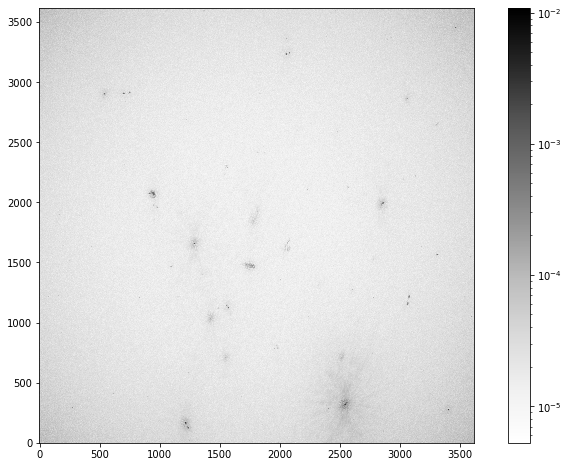

In [31]:
plt.figure(figsize=(12,8))
plt.imshow(linpol_intens_freqmean.clip(min=0.0000001), cmap='Greys', origin='lower', norm=colors.LogNorm(), interpolation='nearest')
plt.colorbar()

ap_patches = apertures.plot(color='white', lw=0.05, label='Photometry aperture')
#ann_patches = annulus_apertures.plot(color='red', lw=0.05, label='Background annulus')
#handles = (ap_patches[0], ann_patches[0])

#plt.legend(facecolor='#458989', labelcolor='white', handles=handles, prop={'weight': 'bold', 'size': 11})
plt.savefig('ACO85_Linpol_Photometry.pdf', dpi=300)

In [32]:
I_phot_table = np.zeros((12, len(sources)))
Q_phot_table = np.zeros((12, len(sources)))
U_phot_table = np.zeros((12, len(sources)))
V_phot_table = np.zeros((12, len(sources)))

for n in range(12):
    I_slice_phot = photometry(I_cube[n], apertures)
    Q_slice_phot = photometry(Q_cube[n], apertures)
    U_slice_phot = photometry(U_cube[n], apertures)
    V_slice_phot = photometry(V_cube[n], apertures)
    for i in range(len(sources)):
        I_phot_table[n, i] = I_slice_phot[i]['flux']
        Q_phot_table[n, i] = Q_slice_phot[i]['flux']
        U_phot_table[n, i] = U_slice_phot[i]['flux']
        V_phot_table[n, i] = V_slice_phot[i]['flux']

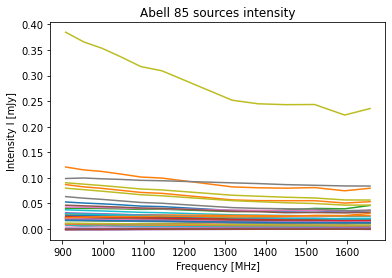

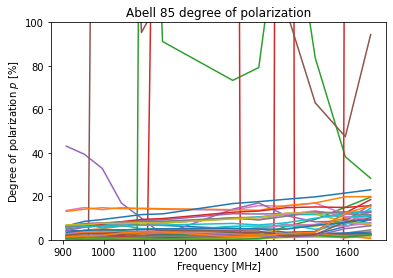

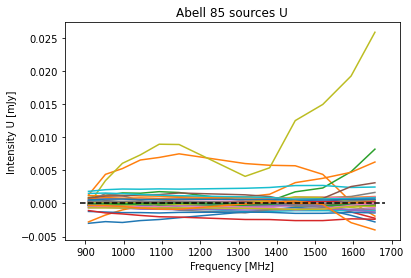

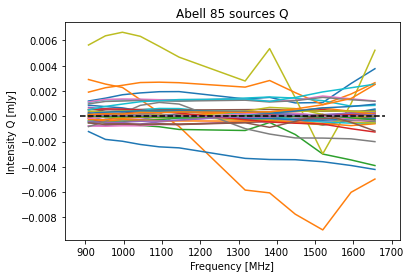

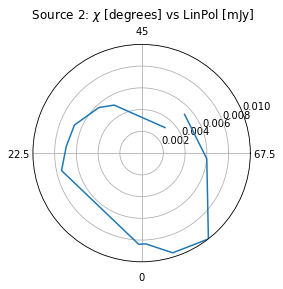

In [39]:
Pol_Angles = 0.5*np.arctan(U_phot_table/Q_phot_table)
Linpol = np.sqrt(U_phot_table**2 + Q_phot_table**2)

plt.title('Abell 85 sources intensity')
plt.plot(freqs_middle/1e6, I_phot_table)
plt.xlabel('Frequency [MHz]')
plt.ylabel('Intensity I [mJy]')
plt.show()

plt.title('Abell 85 degree of polarization')
plt.plot(freqs_middle/1e6, 100*Linpol/I_phot_table)
plt.xlabel('Frequency [MHz]')
plt.ylabel('Degree of polarization $p$ [%]')
plt.ylim(0,100)
plt.show()

plt.title('Abell 85 sources U')
plt.plot(freqs_middle/1e6, U_phot_table)
plt.hlines(0, min(freqs_lower)/1e6, max(freqs_upper)/1e6, color='black', linestyle='dashed')
plt.xlabel('Frequency [MHz]')
plt.ylabel('Intensity U [mJy]')
plt.show()

plt.title('Abell 85 sources Q')
plt.plot(freqs_middle/1e6, Q_phot_table)
plt.hlines(0, min(freqs_lower)/1e6, max(freqs_upper)/1e6, color='black', linestyle='dashed')
plt.xlabel('Frequency [MHz]')
plt.ylabel('Intensity Q [mJy]')
plt.show()

fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
ax.plot(4*Pol_Angles[:,1], Linpol[:,1])
ax.set_rmax(0.01)
ax.set_xticks(np.pi/180 * np.linspace(270,  0, 4))
ax.set_xticklabels([r'$0$', r'$22.5$', r'$45$', r'$67.5$'], fontsize=10)
ax.grid(True)
ax.set_title(r" Source 2: $\chi$ [degrees] vs LinPol [mJy]")
plt.show()